In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score



In [3]:
train = pd.read_csv('./train.csv')
train_df = train.copy()

In [4]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
train_df["Title"][0]

'Wall St. Bears Claw Back Into the Black (Reuters)'

In [6]:
train_df["Description"][0]

"Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [7]:
# checking for missing values
train_df.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [8]:
# Combining title and description
train_df['Text'] = train_df['Title'] +' '+ train_df['Description']

# download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Create a set of English stopwords (common words like 'and', 'is', etc.)
stop_words = set(stopwords.words('english'))
# Adding 'Reuters' as a custom stopword given its frequency in news articles
stop_words.update(['new', 'said', 'say', 'saying', 'says', 'ha', '39s', 'ap', 'wa', 'reuters', 'year', 'afp', 'inc', 'seeing'])
# Instantiate a lemmatizer object for converting words to their base or root form
lemmatizer = WordNetLemmatizer()

# Define a preprocessing function for text data
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations and special characters
    tokens = nltk.word_tokenize(text)  # Tokenize text to individual words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each token to its root form
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords from tokenized text
    return ' '.join(tokens)   # Join the processed tokens back into a string and return

# applying the preprocessing function to 'Text' column
train_df['Text'] = train_df['Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# show og text and preprocessed text in the slide

In [10]:
train_df['Text'][0]

'wall st bear claw back black shortsellers wall street dwindlingband ultracynics green'

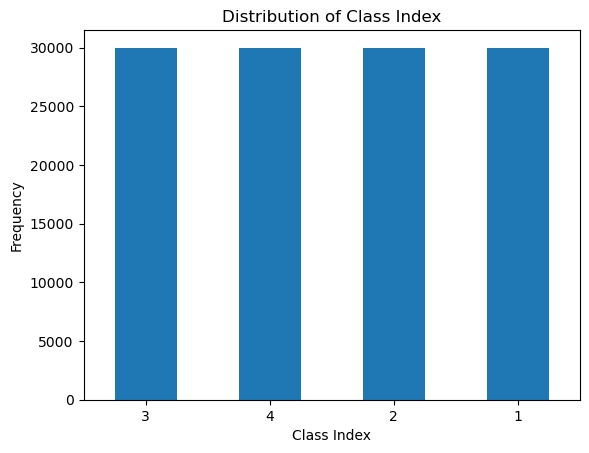

In [11]:

# Plotting the distribution of 'Class Index' without grid

train_df['Class Index'].value_counts().plot(kind='bar', grid=False)

# Adding labels and title
plt.title('Distribution of Class Index')
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal

# Show the plot
plt.show()


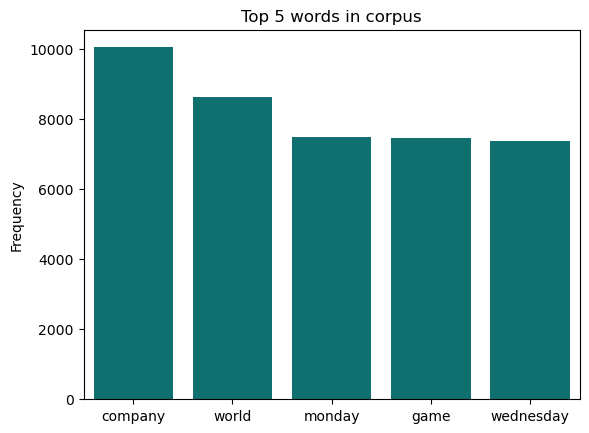

In [12]:
# Function to plot top n most frequent words
def plot_top_n_words(corpus, n=5, bar_color = 'teal'):
    # Initialize CountVectorizer
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    # Compute word frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # Create a dataframe with the most common words and their frequencies
    top_words_df = pd.DataFrame(words_freq[:n])
    top_words_df.columns=["Word", "Freq"]

    # Plot
    sns.barplot(x="Word", y="Freq", data=top_words_df, color=bar_color)
    plt.title(f"Top {n} words in corpus")
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()

# Plot the top 5 words in the entire corpus
plot_top_n_words(train_df['Text'], n=5)

In [13]:
# Change plots below

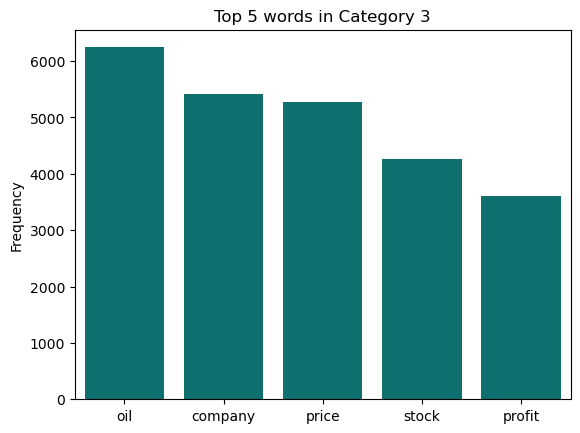

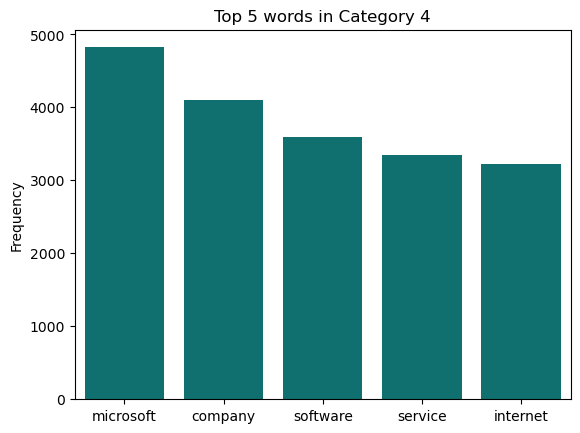

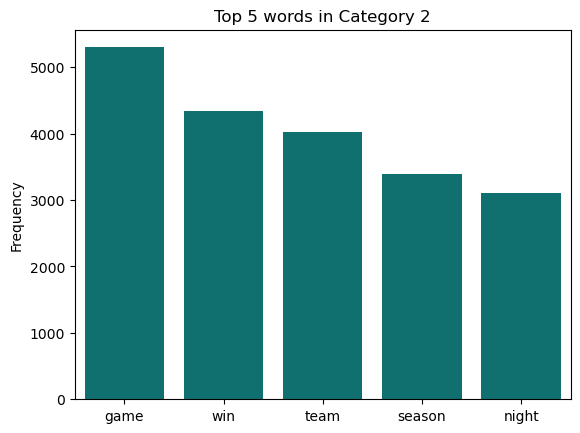

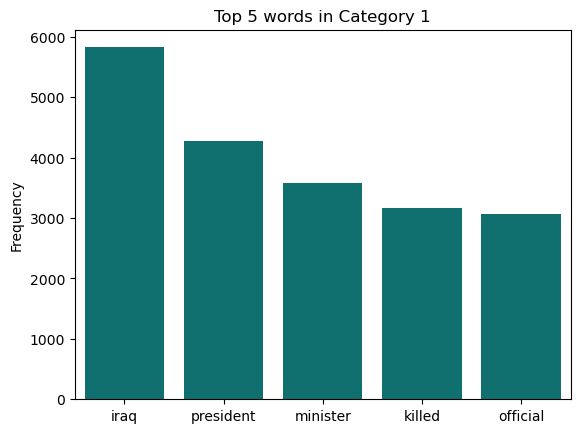

In [14]:
# Modified function to plot top n words for a specific category
def plot_top_n_words_for_category(corpus, category, n=5, bar_color = 'teal'):
    # Filter the corpus for the given category
    category_corpus = corpus[corpus['Class Index'] == category]['Text']

    # Initialize CountVectorizer
    vec = CountVectorizer(stop_words='english').fit(category_corpus)
    bag_of_words = vec.transform(category_corpus)
    sum_words = bag_of_words.sum(axis=0) 

    # Compute word frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Create a dataframe with the most common words and their frequencies
    top_words_df = pd.DataFrame(words_freq[:n])
    top_words_df.columns=["Word", "Freq"]

    # Plot
    sns.barplot(x="Word", y="Freq", data=top_words_df, color=bar_color)
    plt.title(f"Top {n} words in Category {category}")
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

# Plot the top 5 words for each category
for category in train_df['Class Index'].unique():
    plot_top_n_words_for_category(train_df, category, n=5)


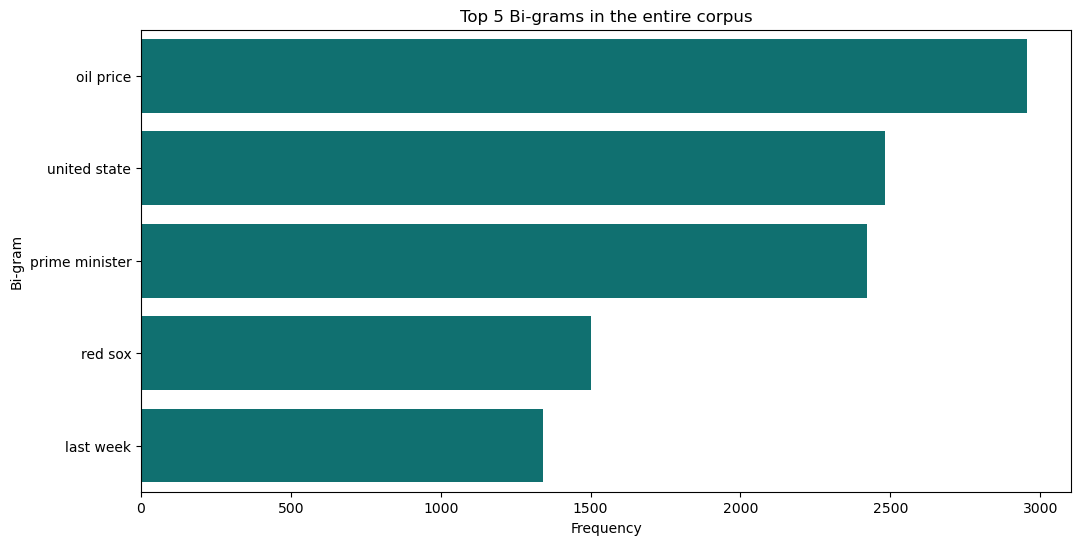

In [15]:
# Function to get top n n-grams
def get_top_n_grams(corpus, n=4, ngram_range=(2, 2)):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 10 bi-grams in the entire corpus
top_bigrams = get_top_n_grams(train_df['Text'], n=5, ngram_range=(2, 2))

# Convert to DataFrame for easy visualization
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bi-gram', 'Frequency'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Bi-gram', data=top_bigrams_df, color='teal')
plt.title('Top 5 Bi-grams in the entire corpus')
plt.show()


In [17]:
# Mapping dictionary
category_mapping = {
    1: 'world',
    2: 'sports',
    3: 'business',
    4: 'science'
}

# Apply the mapping to the dataset
train_df['Category_Name'] = train_df['Class Index'].map(category_mapping)

# Feature extraction
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train_df['Text'])  # Assuming 'text' is the combined column
y = train_df['Category_Name']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Initialize models
nb_model = MultinomialNB()
lr_model = LogisticRegression()
svm_model = SVC()

# Create a dictionary to store models
models = {
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "SVM": svm_model
}

In [19]:

# Function to train and evaluate a model
def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Training and evaluating each model
results = {}
for name, model in models.items():
    results[name] = train_evaluate(model, X_train, y_train, X_test, y_test)

# Display results
for model_name, metrics in results.items():
    print(f"{model_name} - Accuracy: {metrics[0]}, Precision: {metrics[1]}, Recall: {metrics[2]}, F1 Score: {metrics[3]}")

c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes - Accuracy: 0.904625, Precision: 0.9044003009175412, Recall: 0.904625, F1 Score: 0.9043245310493288
Logistic Regression - Accuracy: 0.9123333333333333, Precision: 0.9122580978599912, Recall: 0.9123333333333333, F1 Score: 0.9121296442758959
SVM - Accuracy: 0.9184583333333334, Precision: 0.9185529149076144, Recall: 0.9184583333333334, F1 Score: 0.9182752884075965


In [52]:
def preprocess_input_text(text):
    # Apply the same preprocessing as was done to the training data
    # For example, lowercasing, removing punctuation, etc.
    # You should use the same 'preprocess_text' function you used for training data
    processed_text = preprocess_text(text)
    return processed_text

def predict_category(text, model, vectorizer):
    # Preprocess the input text
    processed_text = preprocess_input_text(text)

    # Transform the text using the trained TF-IDF vectorizer
    text_vector = vectorizer.transform([processed_text])

    # Predict the category
    predicted_category = model.predict(text_vector)[0]

    return predicted_category

# Example usage
input_sentence = "he scored a goal in penalty."
predicted_category = predict_category(input_sentence, model, tfidf)
print(f"The predicted category is: {predicted_category}")


The predicted category is: sports
